In [1]:
from __future__ import annotations
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

%matplotlib inline

In [2]:
words: list[str] = open("names.txt", "r").read().splitlines()

In [3]:
# Gets all the characters, a-z
chars: list[str] = sorted(list(set("".join(words))))

# Maps each character to an integer
stoi: dict[str, int] = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0

# Maps each integer to a character
itos: dict[int, str] = {i: s for s, i in stoi.items()}
vocab_size: int = len(stoi)

In [4]:
# build the dataset
block_size = (
    3  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [5]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP
n_embd = 10  # Embedding dimension
n_hidden = 200  # Neurons in hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn((vocab_size), generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum([p.nelement() for p in parameters]))
for p in parameters:
    p.requires_grad = True

11897


In [7]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1  # Hidden layer weighted inputs
    h = torch.tanh(hpreact)  # Hidden layer activations
    logits = h @ W2 + b2  # Output layer
    loss = F.cross_entropy(logits, Yb)  # Loss function

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Logging
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.8050
  20000/ 200000: 2.5518
  30000/ 200000: 2.8035
  40000/ 200000: 2.0476
  50000/ 200000: 2.7033
  60000/ 200000: 2.3179
  70000/ 200000: 2.0966
  80000/ 200000: 2.3344
  90000/ 200000: 2.2155
 100000/ 200000: 2.0712
 110000/ 200000: 2.4086
 120000/ 200000: 1.8661
 130000/ 200000: 2.3103
 140000/ 200000: 2.2350
 150000/ 200000: 2.1742
 160000/ 200000: 2.1190
 170000/ 200000: 1.7579
 180000/ 200000: 2.0183
 190000/ 200000: 1.8186


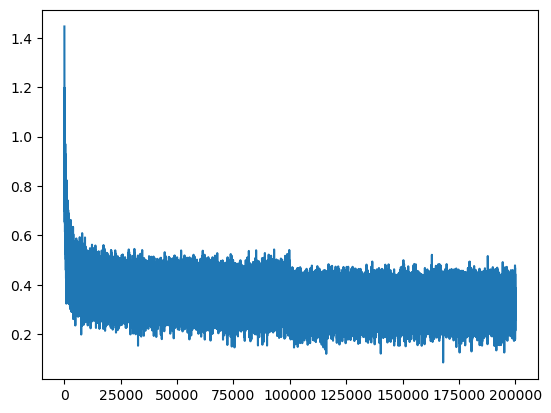

In [8]:
plt.plot(lossi)

In [10]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.1256532669067383
val 2.1684703826904297


In [11]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]  # (1,block_size,n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print("".join(itos[i] for i in out))

carlah.
amille.
khy.
mili.
taty.
skanden.
jazonen.
den.
art.
kaqui.
nextara.
chaiir.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
wazthoniearyn.
kai.
